In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
PATH = './dataset'
IMAGE_SIZE = 32

images = []

In [3]:
for subdir in os.listdir(PATH):
    for name in os.listdir(os.path.join(PATH, subdir)):
        image = tf.keras.utils.load_img(os.path.join(PATH, subdir, name), target_size = (IMAGE_SIZE, IMAGE_SIZE))
        target_size = (IMAGE_SIZE, IMAGE_SIZE)
        
        image = tf.keras.utils.img_to_array(image)
        image /= 255
        images.append(image)

In [4]:
images = np.array(images)
print("Before", images.shape)

Before (1495, 32, 32, 3)


In [10]:
images = np.reshape(images, (images.shape[0], IMAGE_SIZE*IMAGE_SIZE*3))

# Splitting

In [14]:
train_size = int(len(images) * 0.6)

images = tf.random.shuffle(images)
train_data = images[:train_size]
test_data = images[train_size:]

# Restricted Boltzman machine

In [25]:
class RBM(object):
    def __init__(self, input_size, output_size, learning_rate = 0.01, batch_size = 64):
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # initiate weight, visible bias, hidden bias as 0
        self.weight = tf.zeros([input_size, output_size], tf.float32)
        self.visible_bias = tf.zeros([input_size])
        self.hidden_bias = tf.zeros([output_size])
        
    def probability_h_given_v(self, visible, weight, hidden_bias):
        return tf.nn.sigmoid(tf.matmul(visible, weight) + hidden_bias)
    
    def probability_v_given_h(self, hidden, weight, visible_bias):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(weight)) + visible_bias)
    
    def sampele_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random.uniform(tf.shape(probs))))
    
    def update_weight_bias(self, positive_gradient, negative_gradient, batch, h0, v1, h1):
        self.weight += self.learning_rate * (positive_gradient - negative_gradient) / tf.dtypes.cast(tf.shape(batch)[0], tf.float32)
        self.visible_bias += self.learning_rate * tf.reduce_mean(batch - v1, 0)
        self.hidden_bias += self.learning_rate * tf.reduce_mean(h0 - h1, 0)
    
    # Training    
    def train(self, x_train, epochs):
        losses = []
        
        for epoch in range(epochs):

            for start, end in zip(range(0, len(x_train), self.batch_size), range(self.batch_size, len(x_train), self.batch_size)):
                batch = x_train[start:end]
                
                h0 = self.sampele_prob(self.probability_h_given_v(batch, self.weight, self.hidden_bias))
                v1 = self.sampele_prob(self.probability_v_given_h(h0, self.weight, self.visible_bias))
                h1 = self.probability_h_given_v(v1, self.weight, self.hidden_bias)
                
                positive_gradient = tf.matmul(tf.transpose(batch), h0)
                negative_gradient = tf.matmul(tf.transpose(v1), h1)
                
                self.update_weight_bias(positive_gradient, negative_gradient, batch, h0, v1, h1)
                
            
            loss = tf.reduce_mean(tf.square(batch - v1)) # RMSE
            print(f"Epoch {epoch+1}, Reconstruction Loss = {loss}")
            losses.append(loss)
            
        return losses
    
    def reconstruct(self, x_recon):
        h = self.probability_h_given_v(x_recon, self.weight, self.hidden_bias)
        reconstruction = self.probability_v_given_h(h, self.weight, self.visible_bias)
        
        return reconstruction

In [26]:
INPUT_SIZE = train_data.shape[1]

In [27]:
model = RBM(INPUT_SIZE, 1000)
loss = model.train(train_data, epochs=200)

Epoch 1, Reconstruction Loss = 0.20127134025096893
Epoch 2, Reconstruction Loss = 0.19909174740314484
Epoch 3, Reconstruction Loss = 0.19679947197437286
Epoch 4, Reconstruction Loss = 0.19956563413143158
Epoch 5, Reconstruction Loss = 0.18668274581432343
Epoch 6, Reconstruction Loss = 0.19932906329631805
Epoch 7, Reconstruction Loss = 0.19959230720996857
Epoch 8, Reconstruction Loss = 0.18492938578128815
Epoch 9, Reconstruction Loss = 0.18197864294052124
Epoch 10, Reconstruction Loss = 0.1810494065284729
Epoch 11, Reconstruction Loss = 0.1798250675201416
Epoch 12, Reconstruction Loss = 0.18056440353393555
Epoch 13, Reconstruction Loss = 0.17810241878032684
Epoch 14, Reconstruction Loss = 0.174463152885437
Epoch 15, Reconstruction Loss = 0.17216823995113373
Epoch 16, Reconstruction Loss = 0.16782860457897186
Epoch 17, Reconstruction Loss = 0.16501778364181519
Epoch 18, Reconstruction Loss = 0.16351377964019775
Epoch 19, Reconstruction Loss = 0.16183902323246002
Epoch 20, Reconstruction 

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

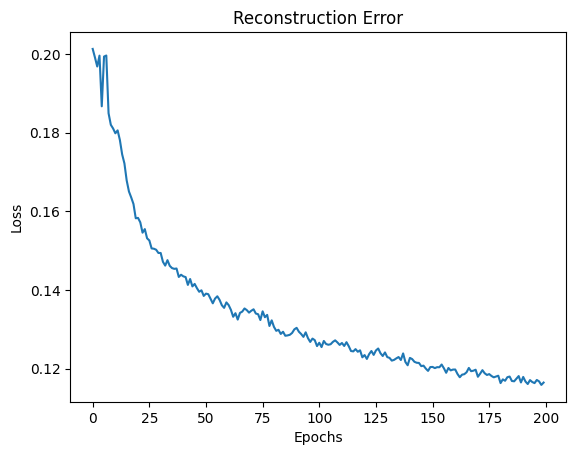

In [28]:
plt.plot(loss)
plt.title("Reconstruction Error")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.plot

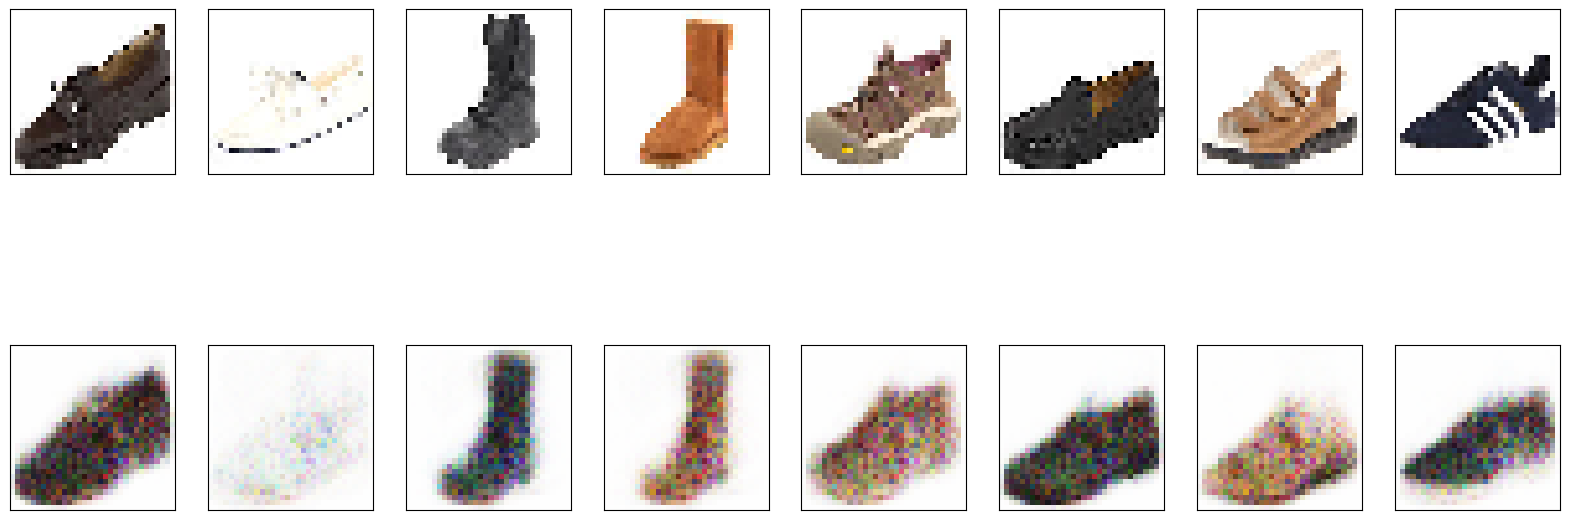

In [30]:
output = model.reconstruct(test_data)

row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)

fig, axes = plt.subplots(row, col, figsize=(20,8))
for figures, row in zip([test_data, output], axes):
    for i, ax in zip(idx, row):
        ax.imshow(tf.reshape(figures[i], (IMAGE_SIZE, IMAGE_SIZE, 3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)